<a href="https://colab.research.google.com/github/LachlanSharp/Lorem-ipsum/blob/main/A3_Lachlan_Sharp_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MA5851 - Assessment 3: WebCrawler and NLP System

---

* **Task 3**: NLP Tasks
* **Author**: Lachlan Sharp
* **Due Date**: 2021-12-08

---



---

# Setup of data-project 

## Import Dependencies

In [42]:
import os.path # Operating system interface
#from time import time, sleep # Time access and conversions
#from datetime import datetime # Basic date and time types

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns # statistical data visulisation

import random # Generate pseudo-random numbers

import gensim # Topic modelling
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import Phrases

# spacy for lemmatization
import spacy # Industrial-strength natural language processing

import nltk # Natural Language Toolkit
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

!pip install unidecode
from unidecode import unidecode # ASCII representation of Unicode strings
import html # HyperText Markup Language support
import re # regular expressions

from pprint import pprint # Data pretty printer

# Get python version
import platform # Platform’s identifying data
print('\nPython version {}'.format(platform.python_version()))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!

Python version 3.7.12


## User defined functions


In [2]:
def mk_dir(path):
    """
    Creates a directory if it doesn't exist

    Parameters:
    -----------
    str : path
        The full directory path for the folder to be created.
        Note: the path should not terminate with a '/'

    Returns:
    --------
    bool
        If folder exists, True, otherwise, False
    """
    if not os.path.exists(path):
        try:
            os.makedirs(path)
        except:
            pass
    return os.path.exists(path)


def print_column_search_contains(df, pattern, print_long = True, max_print_per_feature = 1000):
    """
    Iterates through the columns of a dataframe and prints entry which
    contain matches to the passed regex pattern.

    The function is intended as data exploration tool.
    """

    for colname in df.select_dtypes(include='object').columns:
        print(colname)
        print("`{}`\t(First {} results)".format(colname, max_print_per_feature))
        print("========================")
        string_list = [val for val in df[colname] if isinstance(val, str)]
        string_list = [string for string in string_list if bool(re.search(pattern, string))]
        if print_long:
            for x in string_list[:max_print_per_feature]:
                print(x)           
        else:
            print(string_list[:max_print_per_feature])
        print()




def get_column_search_findall(df, pattern, unique_only=True):
    """
    Iterates through the columns of a dataframe and prints entry which
    contain matches to the passed regex.

    The function is intended as data exploration tool.
    """
    search_results = []
    for colname in df.select_dtypes(include='object').columns:
        string_list = [val for val in df[colname] if isinstance(val, str)]
        string_list = [re.findall(pattern, string) for string in string_list if bool(re.search(pattern, string))]
        for string in string_list:
            search_results.append(string)
    
    search_results = sum(search_results,[])
    if unique_only:
        search_results = list(set(search_results))
    return search_results



def set_dictionary_subst(oldtext_list, newtext = ''):
    """
    Creates a dictionary of replacement values for use with pandas 
    `.replace()` method.

    Implementation would be as follows:

        subst_dict = set_dictionary_subst(oldtext_list, newtext = '')
        df.replace(to_replace = replace_dict, regex = True)

    Parameter:
    ----------
    oldtext : list (of str)
        A list of strings to be replaced
    newtext: str
        A text value to be substituted

    Returns:
    --------
    dict
        A dictionary of regex escaped entries consisting of
            oldtext : newtext
    """

    if isinstance(oldtext_list, list):
        # Get unique entries by converting the list to a set
        subst_dict = {re.escape(oldtext) : newtext for oldtext in set(oldtext_list)}
    elif isinstance(oldtext_list, set):
        # Convert to dictionary
        subst_dict = {re.escape(oldtext) : newtext for oldtext in oldtext_list}        
    elif isinstance(oldtext_list, dict):
        subst_dict = oldtext_list
    else:
        subst_dict = oldtext_list
        print(f'parameter `oldtext_list` unexpected type: {type(oldtext_list)}')

    return subst_dict



def stop_and_lemm(document
                  ,stopwords
                  ,lemmatizer
                  ,retain_pos={ 'ALL' : '.' }
                  ):
    """
    Removes stopwords from a document and performs stemming.

    Parameters:
    -----------
    document : str
        the text to be processed
    stopwords : list[str]
        a list of words to be removed
    lemmatizer : function (e.g. nltk.stem.wordnet.WordNetLemmatizer)
        a function that can perform lemmatization using a `.lemmatize()` method
    dict : retain_pos
        a dictionary specifiy which parts of speach (POS) should be retained.
        e.g. {'NOUN' : 'N', 'ADJ' : 'J', 'VERB' : 'V', 'ADV' : 'R' }
        - dictionary values are used to generate a regex for the POS tag match
        - dictionary key are for readability only


    Returns:
    -------
    str
        the document text after processing
    """

    # Split document into a list of individual words
    word_tokens = word_tokenize(document) # nltk
    
    # Retain part of speach tags
    if retain_pos is not None and len(retain_pos) > 0:
        regex_pos = "^(" + "|".join(retain_pos.values()) + ")"    
        pos_tokens = pos_tag(word_tokens)
        word_tokens = [token for token, pos in pos_tokens if bool(re.search(regex_pos, pos))]

    # Lematization and removal of stopwords
    word_tokens = [lemmatizer.lemmatize(token) for token in word_tokens if token not in set(stopwords)]

    # Rejoin text
    document = ' '.join(word_tokens)
    return document



def word_frequencies(corpus, top_n = 50):
    """
    Generates a tally of word frequency from a body of text

    Paramters:
    ---------
    corpus : 
        an iterable object of text documents
    top_n : int
        The top-n occuring words by frequency

    Returns:
    --------
    pandas.dataframe
        A dataframe of two columns: 'word' and 'count'

    """

    all_words = ' '.join([document for document in corpus]) 
    all_words = all_words.split() 
    fdist = nltk.FreqDist(all_words) 
    df_words = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
    
    # selecting top-n most frequent words 
    return df_words.nlargest(columns="count", n = top_n) 

## Set directory paths

Set pertinent file paths and names.

### Mount Google Drive

This section applies to use of this Python notebook within Google Colab.

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Set file paths

In [4]:
# Set directory paths root filepath for data-project
filepath_root = '/content/drive/MyDrive/Colab Notebooks/MA5851/Assessment 3' # data-project root
filepath_data = os.path.join(filepath_root, 'data') # data folder
print("Directory 'data' exists?: {}".format(mk_dir(filepath_data)))

# Set filenames
filename_tophorse_items_df = "df_tophorse_items.csv"
filename_tophorse_item_details_df = "df_tophorse_item_details.csv"

filename_horseforum_threads_df = "df_horseforum_threads.csv" 
filename_horseforum_thread_posts_df = "df_horseforum_thread_posts.csv"
filename_horseforum_thread_pages_df = "df_horseforum_thread_pages.csv"

filename_horseforum_threads_cleaned_df = "df_horseforum_threads_cleaned.csv" 

Directory 'data' exists?: True


# Import data

Load data obtained via the web crawler.

In [ ]:
df_horseforum_threads_raw = pd.read_csv(os.path.join(filepath_data, filename_horseforum_threads_df))
print("Re-imported threads data: {x[0]} rows × {x[1]} cols".format(x = df_horseforum_threads_raw.shape))
df_horseforum_thread_posts_raw = pd.read_csv(os.path.join(filepath_data, filename_horseforum_thread_posts_df))
print("Re-imported posts data: {x[0]} rows × {x[1]} cols".format(x = df_horseforum_thread_posts_raw.shape))
df_horseforum_thread_pages_raw = pd.read_csv(os.path.join(filepath_data, filename_horseforum_thread_pages_df))
print("Re-imported pages data {x[0]} rows × {x[1]} cols".format(x = df_horseforum_thread_pages_raw.shape))

## Explore

In [ ]:
df_horseforum_thread_posts_raw.info()

Feature post_text was NaN in case where a user only posted and image (i.e., a picture of a horse) but no text.

In [ ]:
df_horseforum_thread_posts_raw[df_horseforum_thread_posts_raw['post_text'].isnull()]

## Wrangle

### Rename `df_horseforum_threads` columns

In [ ]:
df_horseforum_threads_raw.rename(
    {colname: colname.replace("item_", "thread_") for colname in df_horseforum_threads_raw.columns}
    ,axis=1
    ,inplace=True
     )
df_horseforum_threads_raw.head()

### Thread's participant count

Participant count for each *thread* was captured (repeatedly) from each of the thread's *pages*. The following combines the `participant_count` feature into the main *thread* dataset.

* *Note*: Participant count could have also been derived via agreggation of the `df_horseforum_thread_posts_raw` dataset.

In [ ]:
# Convert `participant_count` to integer
df_horseforum_thread_pages_raw[['participant_count']] = df_horseforum_thread_pages_raw[['participant_count']].fillna(value=0)
df_horseforum_thread_pages_raw['participant_count'] = df_horseforum_thread_pages_raw['participant_count'].apply(int)
df_horseforum_thread_pages_raw[df_horseforum_thread_pages_raw['participant_count'] == 0]

In [ ]:
# Add `participant_count` feature to the "thread" dataset (from "pages" dataset)
df_horseforum_threads = pd.merge(
    df_horseforum_threads_raw
    ,df_horseforum_thread_pages_raw.drop(['page_url_path'], axis=1).drop_duplicates()
    ,how='left'    
    ,left_on='thread_url_path'
    ,right_on='thread_url_path'
    )

df_horseforum_threads

### Cosolidate thread corpus

Each *thread* consisted of multiple *posts*, where each unique post is its own observation. For the purpose topic modelling, the posts of each thread need to be combined to create one "document" per thread. The wrangleing steps were as follows:

1. Coalesce `NaN` values in the `post_text` feature to empty strings.
2. Group the dataset to produce a list of all posts for a given thread.
3. Concatenate the list of posts into a single document (string).
4. Combine the thread's title into the thread's document

In [ ]:
# Initialise a "processed" version of the orginal data frame
df_horseforum_thread_posts = df_horseforum_thread_posts_raw.copy()

# Convert NaN to empty string
df_horseforum_thread_posts[['post_text']] = df_horseforum_thread_posts[['post_text']].fillna(value="")

In [ ]:
# Group by feature `thread_url_path` to aggregate feature `post_text` into a `list`.
tmpdf = df_horseforum_thread_posts.groupby(['thread_url_path'], as_index = False).agg({'post_text': list})

# Concatenate a thread's posts into a single document
tmpdf['thread_document'] = tmpdf['post_text'].apply('\n'.join)

In [ ]:
# Combine the aggregated post features into the main thread data frame
df_horseforum_threads = pd.merge(
    df_horseforum_threads.drop(['post_text','thread_document']
                               ,axis=1
                               ,errors='ignore' # in case cell run multiple times
                               ) 
    ,tmpdf
    ,how='left'    
    ,left_on='thread_url_path'
    ,right_on='thread_url_path'
    )

# Convert NaN to empty string (occured because of the join)
df_horseforum_threads[['thread_document']] = df_horseforum_threads[['thread_document']].fillna(value="")

df_horseforum_threads['thread_document'] = df_horseforum_threads['thread_title'] + "\n" + df_horseforum_threads['thread_document']

df_horseforum_threads

In [ ]:
# Producin
df_horseforum_threads.info()

# NLP - cleaning corpus

The following performs common cleaning tasks for the corups:

* Remove HTML / URLs / email
* Convert encodings
* Lower case
* Punctuation
* Removal of stopwords

In [6]:
# Intialise a new feature to store the "cleaned" document for each thread
df_horseforum_threads['cleaned_document'] = df_horseforum_threads['thread_document']

## Remove HTML / URLs / email

### Identify

**Websites & URLs**

In [7]:
# Search for website URLs
regex_pattern_website = r'(https?://\S+|ftp://|www[.]\S+)'

# ...too much output to print
#print_column_search_contains(
#    df_horseforum_threads[['cleaned_document']]
#    ,regex_pattern_website
#    ,print_long = False
#    ,max_print_per_feature = 10
#    )
found_websites = get_column_search_findall(df_horseforum_threads[['cleaned_document']]
                                            ,pattern=regex_pattern_website
                                            ,unique_only=False)
print("Total URLs found: {}".format(len(found_websites)))

found_websites = list(set(found_websites))
print("Unique URLs found: {}".format(len(found_websites)))
print()

print("Random sample of URLs:")
if len(found_websites) > 0:
    pprint(
        random.sample(
            found_websites
            ,min(10, len(found_websites))
            )
        )
else:
    print([])

Total URLs found: 5760
Unique URLs found: 4541

Random sample of URLs:
['www.arabhorse.com',
 'http://forums.prospero.com/alexbrown/messages?msg=23344.1&gt;',
 'www.barnmice.com',
 'http://www.horseforum.com/horse-health/how-much-more-weight-does-he-95173/',
 'https://thehorse.com/110110/all-about-alfalfa/',
 'https://goo.gl/forms/112vgkLMYV8uj5Wx2',
 'http://i.imgur.com/EmtXI7M.jpg',
 'http://www.horseforum.com/horse-grooming/crystal-looking-dranduf-mane-tail-131573/#post1606223',
 'http://www.aaep.org/core_vaccinations.htm',
 'http://www.prevenile.com/PDF/PreveNile']


As an exploratory task, unique URL domains were investigated.

In [8]:
domains_list = [re.findall(r'^[^/]+', url_cleaned) for url_cleaned in [re.sub(r'https?://|ftp://', '', url) for url in found_websites]]
domains = []
for domain in domains_list:
    domains.append(domain)
domains = sum(domains,[])
domains = set(domains)

print("Unique URL domains found: {}".format(len(domains)))
print()

print("Random sample of domains:")
if len(domains) > 0:
    pprint(
        random.sample(
            domains
            ,min(10, len(domains))
            )
        )
else:
    print([])

Unique URL domains found: 1716

Random sample of domains:
['www.independentequineagents.com',
 'www.icelandichorses.co.uk',
 'media.wix.com',
 'www.eclipseforwounds.com',
 'www.paddockparadise.wetpaint.com',
 'www.synergistsaddles.com',
 'www.admani.com',
 'www.claramasondvm.com',
 'www.cvmbs.colostate.edu',
 'www.greatmats.com']


**Email addresses**

In [9]:
# Search for email addresses
regex_pattern_email = r'(?i)\b[A-Z0-9._%+-]+@[A-Z0-9.-]+\.[A-Z]{2,}\b'
found_email = get_column_search_findall(df_horseforum_threads[['cleaned_document']]
                                            ,pattern=regex_pattern_email
                                            ,unique_only=False)
print("Total email addresses found: {}".format(len(found_email)))

found_email = list(set(found_email))
print("Unique email addresses found: {}".format(len(found_email)))
print()

print("Random sample of email addresses:")
if len(found_email) > 0:
    pprint(
        random.sample(
            found_email
            ,min(10, len(found_email))
            )
        )
else:
    print([])

Total email addresses found: 0
Unique email addresses found: 0

Random sample of email addresses:
[]


**HTML tags**

In [10]:
# Search for HTML tags
regex_pattern_html_tag = r'<[^>]+>'
found_tag = get_column_search_findall(df_horseforum_threads[['cleaned_document']]
                                            ,pattern=regex_pattern_html_tag
                                            ,unique_only=False)
print("Total tags found: {}".format(len(found_tag)))

found_tag = list(set(found_tag))
print("Unique tags found: {}".format(len(found_tag)))
print()

print("Random sample of tags:")
if len(found_tag) > 0:
    pprint(
        random.sample(
            found_tag
            ,min(10, len(found_tag))
            )
        )
else:
    print([])

Total tags found: 2
Unique tags found: 2

Random sample of tags:
['<SPAN class=threadTitle>', '<</SPAN>']


### Remove

The following sections removes the following identified elements from the thread's document:

* URLs
* email addresses
* HTML tags



<div class="alert alert-block alert-success">

<table>
<tr>
<td>

*Note*: A prior methodlogy attempted to remove the unwanted elements by converting them to a dictionary (via user-defined function `set_dictionary_subst(found_websites)`)  and using `pandas` `replace()` method as below&mdash;however this proved to be much to slow for a corpus this size.

```python
df_horseforum_threads['cleaned_document'].replace(subst_dict_websites, regex = True, inplace=True)
```

</td>
</tr>
</table>
</div>

In [11]:
# Remove unwanted elements
print("Remove website URLs...")
df_horseforum_threads['cleaned_document'] = [re.sub(regex_pattern_website, '', text) for text in df_horseforum_threads['cleaned_document']]
print("Remove email addresses...")
df_horseforum_threads['cleaned_document'] = [re.sub(regex_pattern_email, '', text) for text in df_horseforum_threads['cleaned_document']]
print("Remove HTML tags...")
df_horseforum_threads['cleaned_document'] = [re.sub(regex_pattern_html_tag, '', text) for text in df_horseforum_threads['cleaned_document']]
print("...completed")

Remove website URLs...
Remove email addresses...
Remove HTML tags...
...completed


## Character Encoding

**Unicode to ASCII**

In case there were any diacritic characters ('accented' characters), e.g.: à, ě, ī, ō, ū etc., such Unicode characters were decoded into "equivalent" ASCII characters. This was accomplished  using the Python `unidecode` library (https://pypi.org/project/Unidecode/).

**HTML escape characters**

Any HTML character escapes (refer https://www.w3.org/International/questions/qa-escapes),  were "unescaped" using the  `html.unescape()` function (e.g., quotations marks: `&quot;` $\rightarrow$ `"`).


In [12]:
# Unescape HTML characters
print("Unescape HTML escapes...")
df_horseforum_threads['cleaned_document'] = [html.unescape(text) if isinstance(text, str) else text for text in df_horseforum_threads['cleaned_document']]
# Convert Unicode to ASCII
print("Convert Unicode to ASCII...")
df_horseforum_threads['cleaned_document'] = [unidecode(text) if isinstance(text, str) else text for text in df_horseforum_threads['cleaned_document']]
print("...completed")

Unescape HTML escapes...
Convert Unicode to ASCII...
...completed


## Replace new-lines, punctuation, digits, excess whitespace

In [13]:
df_horseforum_threads['cleaned_document'].replace(
    {
        r'(\n|\r)+' : " "   # replace new-lines
        ,r'\W' : " "        # replace non-word characters
        ,r'\b\d+\b' : " "   # repalce strings of digits
        ,r'\s+' : ' '       # reduce multiple spaces
     }
    ,regex = True
    ,inplace = True)
df_horseforum_threads

,thread_url_path,thread_document,cleaned_document,cleaned_document_tm
0,/threads/please-read-before-posting-both-older...,PLEASE READ BEFORE POSTING (both older and new...,PLEASE READ BEFORE POSTING both older and newe...,please read posting older newer horseforum com...
1,/threads/poisonous-plants-from-hf-member-locat...,poisonous plants from HF member locations\nMOD...,poisonous plants from HF member locations MOD ...,poisonous plant hf member location note jaydee...
2,/threads/the-care-of-an-emaciated-horse.100412/,The Care of an Emaciated Horse\nMy friend and ...,The Care of an Emaciated Horse My friend and I...,care emaciated horse friend experienced horse ...
3,/threads/making-a-vet-kit.251/,Making a Vet Kit\nHey guys! I am posting this ...,Making a Vet Kit Hey guys I am posting this th...,making vet kit hey guy posting thread primaril...
4,/threads/information-on-myopathies-pssm1-pssm2...,"Information on Myopathies - PSSM1, PSSM2, MFM,...",Information on Myopathies PSSM1 PSSM2 MFM and ...,information myopathy pssm1 pssm2 mfm rer pssm1...
...,...,...,...,...
20949,/threads/recovery-from-torn-rear-suspensory-li...,Recovery from Torn Rear Suspensory Ligament\nH...,Recovery from Torn Rear Suspensory Ligament Hi...,recovery torn rear suspensory ligament hi stan...
20950,/threads/how-to-get-horses-to-gaine-weight.99/,how to get horses to gaine weight\nI found out...,how to get horses to gaine weight I found out ...,get horse gaine weight found give horse black ...
20951,/threads/paxil.102/,PAXIL?\nWe have a horse who is just a simply h...,PAXIL We have a horse who is just a simply hig...,paxil horse simply high strung sort favorite t...
20952,/threads/loose-stool.101/,Loose stool\nI have a three year old filly tha...,Loose stool I have a three year old filly that...,loose stool year old filly tends nervous gut f...


# NLP - Sentiment analysis

# NLP - Topic modelling

In [14]:
# Intialise new feature for topic modelling
df_horseforum_threads['cleaned_document_tm'] = df_horseforum_threads['cleaned_document']

### Lower case

Letter casing is not modified for sentiment alanysis as it capitalization can convey sentiment. In contrast to topic modelling, changing text to lower case reduces dimensionality.

In [15]:
# Convert text to lower case
print("Convert to lower case...")
df_horseforum_threads['cleaned_document_tm'] = df_horseforum_threads['cleaned_document_tm'].apply(str.lower)
print("...completed")

Convert to lower case...
...completed


## Stopwords, Lemmatization, and Parts-of-speach (POS)

In [16]:
%%time
# Remove stops words and lemmatize
stop_words = stopwords.words('english')
#stop_words.extend([''])
lemmatizer = WordNetLemmatizer()
retain_pos = {'NOUN' : 'N', 'ADJ' : 'J', 'VERB' : 'V', 'ADV' : 'R' }
print("Removal stopwords and lemmatization...")
df_horseforum_threads['cleaned_document_tm'] = df_horseforum_threads['cleaned_document_tm'].apply(
    lambda document: stop_and_lemm(document
                                   ,stopwords = stop_words
                                   ,lemmatizer = lemmatizer
                                   ,retain_pos = retain_pos)
    )
print("...completed")

Removal stopwords and lemmatization...
...completed
CPU times: user 23min 3s, sys: 3.62 s, total: 23min 6s
Wall time: 23min 8s


### Word frequency plots

The following plot compares the frequency of word count between the corpus having been stemmed or lemmatized.

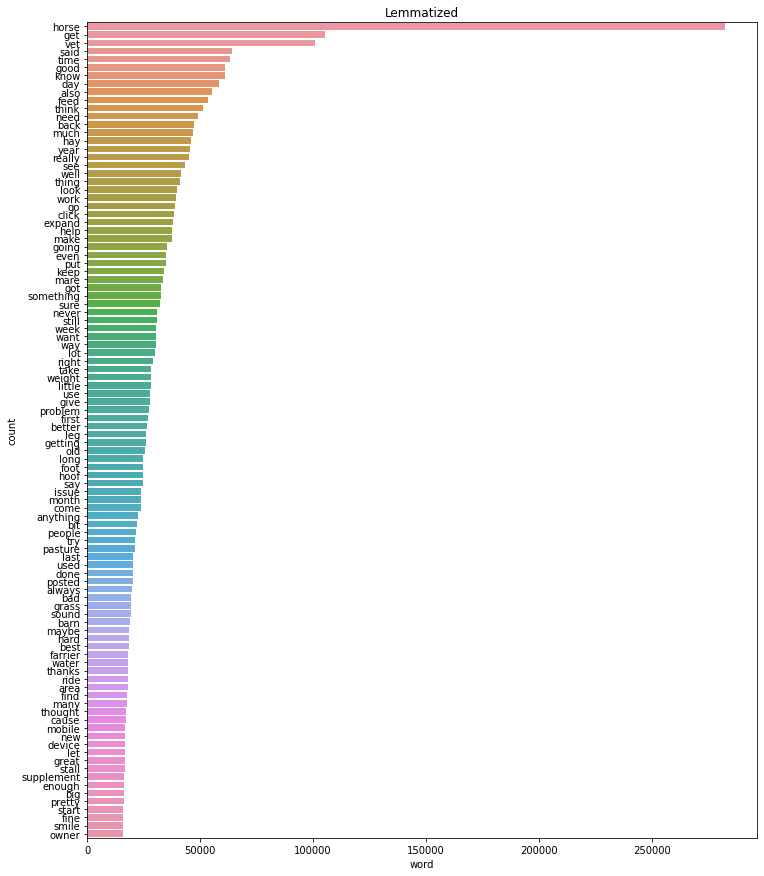

In [17]:
# visualize words and frequencies
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 15))

# Plot Lemmatized word freq.
sns.barplot(ax=ax
            ,data=word_frequencies(df_horseforum_threads['cleaned_document_tm'], top_n = 100)
            ,x="count"
            ,y="word")

ax.set_title("Lemmatized") 
ax.set_xlabel("word")
ax.set_ylabel("count")

# Display plot
plt.show()

### Save processed corpus

In [18]:
# Save dataframe locally
df_horseforum_threads[['thread_url_path', 'thread_document', 'cleaned_document', 'cleaned_document_tm']].to_csv(os.path.join(filepath_data, filename_horseforum_threads_cleaned_df), index=False)

In [5]:
df_horseforum_threads = pd.read_csv(os.path.join(filepath_data, filename_horseforum_threads_cleaned_df))
df_horseforum_threads.shape

(20954, 4)

## Term weights

### Bigrams

In [37]:
%%time
# Convert each thread's document into a list of words
corpus_documents = df_horseforum_threads['cleaned_document_tm'].values.tolist()
corpus_documents = [word_tokenize(document) for document in corpus_documents]

# Build the bigram model
bigram_phrases = gensim.models.Phrases(corpus_documents, min_count=5, threshold=100) # higher threshold fewer phrases.
bigram_phraser = gensim.models.phrases.Phraser(bigram_phrases)
def set_bigrams(corpus):
    return [bigram_phraser[document] for document in corpus]

# Form Bigrams
corpus_document_tokens = set_bigrams(corpus_documents)

CPU times: user 2min 5s, sys: 1.52 s, total: 2min 6s
Wall time: 2min 7s


### TF-IDF

In [43]:
%%time
#LDA topic model requires two things: the dictionary(id2word) and the corpus
# Create Dictionary
corpus_dict = corpora.Dictionary(corpus_document_tokens)
count = 0
for k, v in corpus_dict.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

#filtering words less frequent and high frequent; taking only the top 100,000 keywords
corpus_dict.filter_extremes(no_below=10, no_above=0.5, keep_n=100000)

# Term Document Frequency (Bag of Words Approach)
corpus_bow = [corpus_dict.doc2bow(document) for document in corpus_document_tokens]
tfidf = gensim.models.TfidfModel(corpus_bow)
corpus_tfidf = tfidf[corpus_bow]

0 abuse
1 abusing
2 add
3 added
4 adding
5 admin
6 allow
7 allowed
8 allows
9 answer
10 approach
CPU times: user 15.8 s, sys: 556 ms, total: 16.3 s
Wall time: 16.3 s


## LDA Model

In [50]:
%%time
# Building the LDA topic model
lda_model = gensim.models.LdaMulticore(
    corpus=corpus_tfidf
    ,id2word=corpus_dict    
    ,num_topics=20
    ,passes=20
    ,random_state=987
    ,per_word_topics=True
    ,workers=4
    )

CPU times: user 17min 4s, sys: 35.9 s, total: 17min 40s
Wall time: 19min 52s


In [44]:
%%time
# Building the LDA topic model
lda_model = gensim.models.ldamodel.LdaModel(
    corpus=corpus_tfidf
    ,id2word=corpus_dict
    ,num_topics=20
    ,random_state=987
    ,update_every=1
    ,chunksize=100
    ,passes=20
    ,alpha='auto'
    ,per_word_topics=True
    )

CPU times: user 20min 9s, sys: 10min 45s, total: 30min 55s
Wall time: 18min 54s


In [51]:
%%time
# Print the Keywords in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus_tfidf]

[(0,
  '0.017*"teeth" + 0.011*"sheath" + 0.009*"dentist" + 0.008*"bean" + '
  '0.008*"tooth" + 0.007*"gelded" + 0.006*"wolf_teeth" + 0.005*"mouth" + '
  '0.005*"stallion" + 0.005*"testicle"'),
 (1,
  '0.039*"hoof" + 0.037*"shoe" + 0.034*"farrier" + 0.028*"foot" + 0.019*"trim" '
  '+ 0.018*"barefoot" + 0.016*"thrush" + 0.015*"heel" + 0.013*"frog" + '
  '0.011*"boot"'),
 (2,
  '0.012*"clover" + 0.006*"drool" + 0.005*"drooling" + 0.003*"slobber" + '
  '0.003*"moore" + 0.002*"exodus" + 0.002*"prosthetic" + 0.002*"uncle_jimmy" + '
  '0.002*"waxing" + 0.002*"wax"'),
 (3,
  '0.003*"luvs" + 0.003*"thnx" + 0.002*"weefoal" + 0.002*"calcium_carbonate" + '
  '0.002*"delilah" + 0.002*"herbicide" + 0.002*"outlast" + 0.002*"riboflavin" '
  '+ 0.002*"l_lysine" + 0.002*"dl_methionine"'),
 (4,
  '0.038*"worm" + 0.028*"deworming" + 0.022*"parasite" + 0.019*"ivermectin" + '
  '0.019*"wormer" + 0.017*"worming" + 0.016*"deworm" + 0.015*"dewormer" + '
  '0.014*"resistance" + 0.013*"egg"'),
 (5,
  '0.034*"vac

In [52]:
%%time
#Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus_tfidf))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=corpus_document_tokens, dictionary=corpus_dict, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -9.875975197676851

Coherence Score:  0.6140881620481115
CPU times: user 4min 26s, sys: 1min 8s, total: 5min 35s
Wall time: 4min 19s


# Example 1 - using news text

There were some package dependency issues being caused with `pyLDAvis` so it is imported separately.

In [65]:
# pyLDAvis: interactive topic model visualization
import warnings # package incompatability warnings raised by pyLDAvis
warnings.filterwarnings('ignore') # suppress warnings
!pip install pyLDAvis
import pyLDAvis.gensim_models
from pyLDAvis import gensim_models

In [68]:
import pyLDAvis.gensim_models
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, [corpus_dict.doc2bow(doc) for doc in corpus_document_tokens], corpus_dict)
vis


TypeError: ignored

## Building LDA Mallet Model


In [ ]:
# How to find the optimal number of topics for LDA?
def compute_coherence_values(dictionary, corpus, texts, limit, start=1, step=1):
    """
    Compute coherence score for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

In [ ]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [ ]:
# Select the model and print the topics
optimal_model = model_list[5]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=15))

In [ ]:
print(optimal_model[corpus[1:2]])

In [ ]:
s = sorted(optimal_model[corpus[1:2]][0], key=lambda x: (x[1]), reverse=True)
print(s)

In [ ]:
optimal_model.show_topic(27,topn=15)

In [ ]:
# Finding the dominant topic in each sentence
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

In [ ]:
#Find the most representative document for each topic
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

In [ ]:
# Topic distribution across documents
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics